<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Transfer Learning with TensorFlow Part 2: Fine-tuning

## Create helper functions
In the previous notebooks, we've created a bunch of helper functions,
now we could rewrite them all,however, this is tedious.

So, we download and import it

In [56]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-09-29 17:03:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-09-29 17:03:56 (93.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [57]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google Colab when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time, we're goin to see how to use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [58]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-09-29 17:03:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  22.7MB/s    in 8.4s    

2025-09-29 17:04:05 (19.2 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [59]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [60]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [61]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [62]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [63]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [64]:
# Se an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[7.16428604e+01 2.56428566e+01 3.66428566e+01]
   [7.39285736e+01 2.79285717e+01 3.79285736e+01]
   [7.37857132e+01 2.87857132e+01 3.53571434e+01]
   ...
   [1.79316635e+02 1.68173721e+02 1.63755386e+02]
   [2.06357101e+02 1.90785675e+02 1.85632614e+02]
   [1.57906769e+02 1.38610840e+02 1.34233292e+02]]

  [[7.20714340e+01 2.60714283e+01 3.70714264e+01]
   [7.43571472e+01 2.83571434e+01 3.83571434e+01]
   [7.42142868e+01 2.92142849e+01 3.59693871e+01]
   ...
   [1.31806458e+02 1.13898239e+02 1.06969742e+02]
   [1.56122467e+02 1.33693893e+02 1.26306122e+02]
   [1.28366425e+02 1.04325546e+02 9.58153610e+01]]

  [[7.28979568e+01 2.68979588e+01 3.78979607e+01]
   [7.49285736e+01 2.89285717e+01 3.89285736e+01]
   [7.56530609e+01 3.06530609e+01 3.76530609e+01]
   ...
   [8.47959290e+01 5.78469162e+01 4.53775444e+01]
   [9.17756577e+01 6.04899445e+01 4.71634064e+01]
   [1.00458878e+02 6.67445984e+01 5.21731682e+01]]

  ...

  [[1.26744904e+02 1.41744904e+02 6.07449036e+01]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregrate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs wit the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after base model: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250929-165959
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2099 - loss: 2.2200 - val_accuracy: 0.7039 - val_loss: 1.4106
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.7581 - loss: 1.2218 - val_accuracy: 0.8141 - val_loss: 0.9032
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.8376 - loss: 0.8368 - val_accuracy: 0.8454 - val_loss: 0.7007
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8547 - loss: 0.6504 - val_accuracy: 0.8569 - val_loss: 0.6236
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8871 - loss: 0.5558 - val_accuracy: 0.8668 - val_loss: 0.5733


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.8575 - loss: 0.5771


[0.5676465034484863, 0.8611999750137329]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# How about we get the summary of the base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# How about a summary of our whole model
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

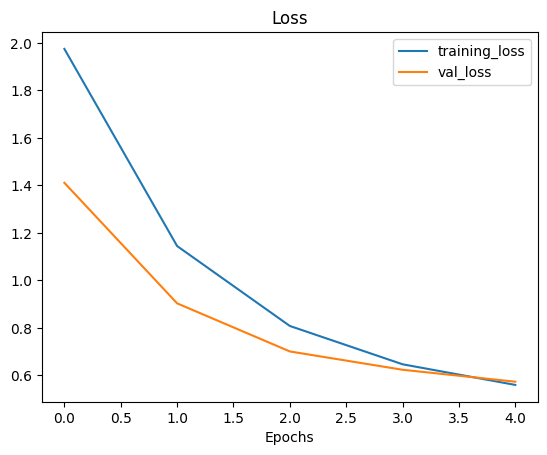

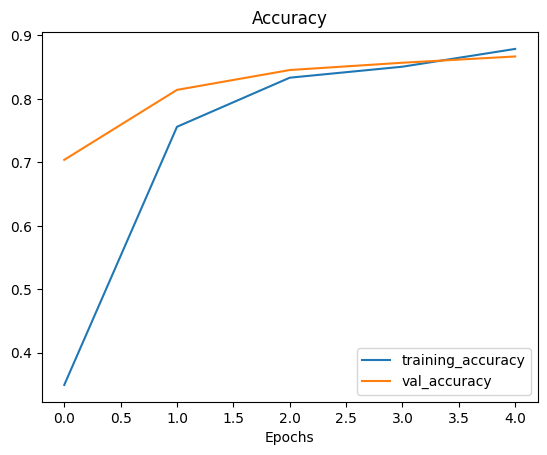

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

In [16]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of inout tensor: {input_tensor.shape}")
print(f"Shape of Gloval Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of inout tensor: (1, 4, 4, 3)
Shape of Gloval Average Pooled 2D tensor: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [18]:
 # Using GlobalMaxPool2D

 global_max_pool = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
 print(f"Global MaxPooled tensor\n: {global_max_pool}\n")
 print(f"Shape of Global MaxPooled tensor:\n {global_max_pool.shape}\n")

 reduced_mean = tf.reduce_mean(input_tensor, axis=[1, 2])
 print(f"Reduced Mean Tensor:\n {reduced_mean}\n")
 print(f"Shape of Reducced Mean Rensor:\n {reduced_mean.shape}")

Global MaxPooled tensor
: [[0.9058464 1.1603122 1.6994323]]

Shape of Global MaxPooled tensor:
 (1, 3)

Reduced Mean Tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of Reducced Mean Rensor:
 (1, 3)


## Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation.
4. `model_4`- use fine-tuning transfer-learning with 100% of the training data with data augmentation.

>**Note:** throughout the experiments, the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for `model_1`

In [19]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-09-29 17:01:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.217.70.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.1MB/s    in 7.2s    

2025-09-29 17:01:27 (17.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
To add data augmentation right into our models, we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation sstage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers. Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's don't need it
], name="data_augmentation")

## Visualize our data augmenetation  layer (and see what happens to our data)

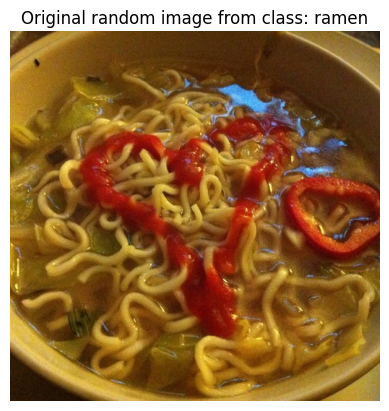

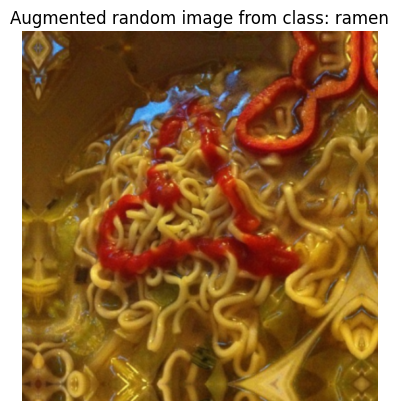

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation sstage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers. Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's don't need it
], name="data_augmentation")

In [26]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape) # Reinstantiate with correct input shape
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs  (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250929-170131
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.1079 - loss: 2.4416 - val_accuracy: 0.1447 - val_loss: 2.3201
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step - accuracy: 0.1892 - loss: 2.1586 - val_accuracy: 0.2188 - val_loss: 2.1736
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 739ms/step - accuracy: 0.3355 - loss: 2.0279 - val_accuracy: 0.2664 - val_loss: 2.0859
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4369 - loss: 1.8553 - val_accuracy: 0.3240 - val_loss: 1.9793
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 743ms/step - accuracy: 0.5228 - loss: 1.7290 - val_accuracy: 0.4145 - val_loss: 1.8722


In [27]:
# Eavluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.4067 - loss: 1.8790


[1.8911900520324707, 0.40560001134872437]

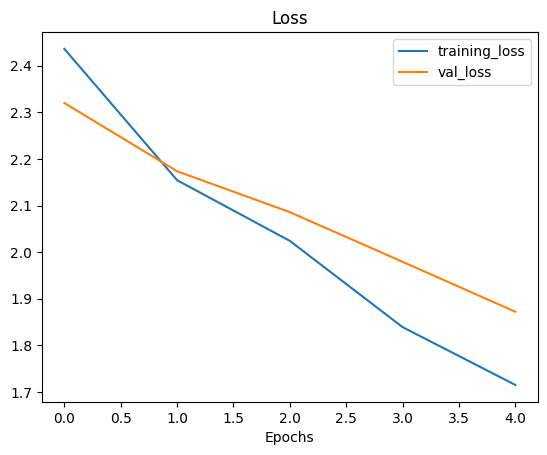

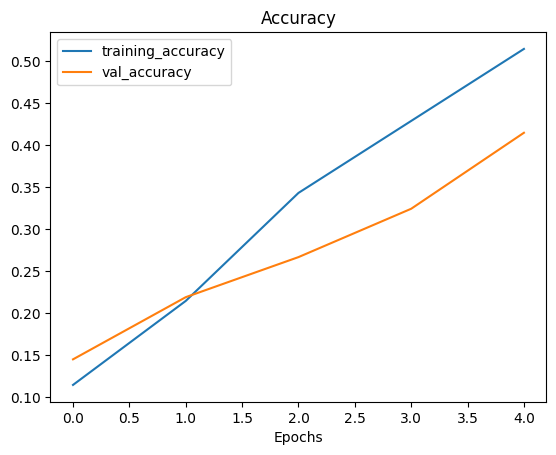

In [ ]:
# How do the model with 1% of data.... loss curves
plot_loss_curves(history_1_percent)

## `model_2`: use feature extraction transfer learning with 10% of the training data with data augmentation

In [29]:
# Get 10% of training data of classes of Food101
# (already done that initially before now)

In [30]:
#CCreate training and test directory paths
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [31]:
# Set data loaders

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# Create model 2 with data augmentation built in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentatioon = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2)], name = "data_augmentation")

In [33]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Givw base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Creating our ModelCheckpoint callback
ModelCheckpoint callback intermediately saves our model (the full model or just he weights) during training.

In [35]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_chckpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [36]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_data_aug"),
                                              checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250929-170215
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2211 - loss: 2.1786
Epoch 1: saving model to ten_percent_model_chckpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - accuracy: 0.2263 - loss: 2.1708 - val_accuracy: 0.6891 - val_loss: 1.4648
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6838 - loss: 1.4204
Epoch 2: saving model to ten_percent_model_chckpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.6839 - loss: 1.4174 - val_accuracy: 0.7862 - val_loss: 1.0057
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7797 - loss: 1.0549
Epoch 3: saving model to ten_percent_model_chckpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.7799 - loss: 1.0532 - val_accuracy: 0.8224 - val_loss: 0.7980
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - a

In [37]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8433 - loss: 0.6373


[0.6301723718643188, 0.8452000021934509]

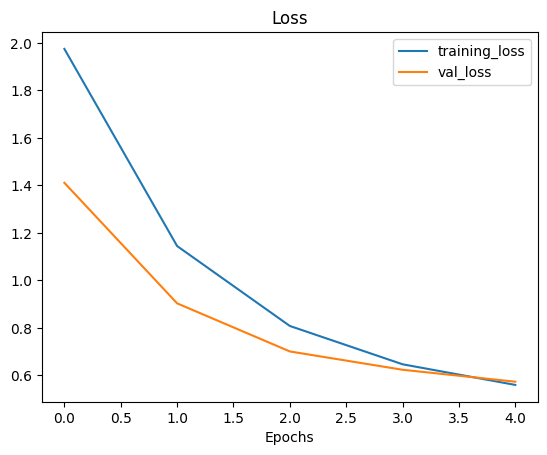

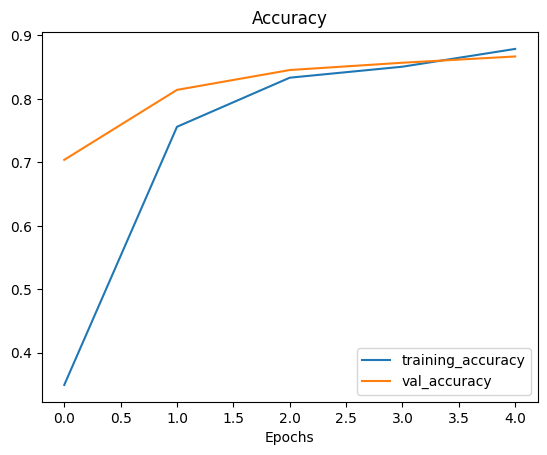

In [38]:
# Plot model's loss curve
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights
Loaded in checkpointed weights  returns a model to a specific checkpoint.

In [39]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [40]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8462 - loss: 0.6325


In [41]:
# If the results from our prevoiusly evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [42]:
results_10_percent_data_aug

[0.6301723718643188, 0.8452000021934509]

In [43]:
loaded_weights_model_results

[0.6301723122596741, 0.8452000021934509]

## Model 3: Fine-tunning the model with 10% of the data with data augmentation

In [44]:
# Layers in loaded model
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [45]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [46]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_layer_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [47]:
# How many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 110
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate.
                metrics=["accuracy"])

>**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [49]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [50]:
# Now we've unfrozen some of the layers cloer to the top, how many trainable ariables are there?
print(len(model_2.trainable_variables))

12


In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layes)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data= test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent.epoch[-1], # start from previous last epoch
                                           callbacks=[create_tensorboard_callback(dir_name="tansfer_learning",
                                                                                  experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: tansfer_learning/10_percent_fine_tune_last_10/20250929-170304
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.7775 - loss: 0.8486 - val_accuracy: 0.8372 - val_loss: 0.5676
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.7999 - loss: 0.7359 - val_accuracy: 0.8503 - val_loss: 0.5295
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8359 - loss: 0.6048 - val_accuracy: 0.8405 - val_loss: 0.5079
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.8497 - loss: 0.5829 - val_accuracy: 0.8503 - val_loss: 0.4778
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8774 - loss: 0.5303 - val_accuracy: 0.8553 - val_loss: 0.4723
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.8771 - loss: 0.4545 - val_accuracy: 0.8536 - val_loss: 0.4555


In [52]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8617 - loss: 0.4427


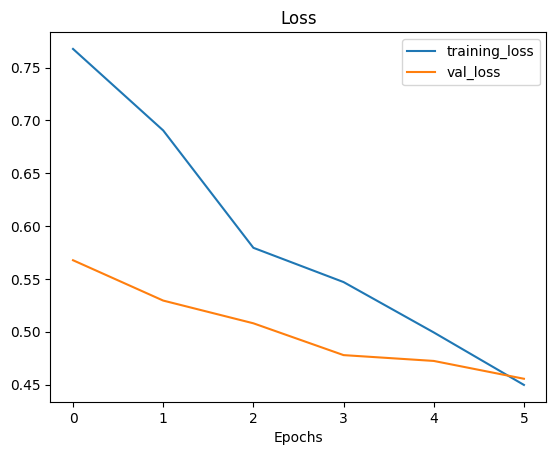

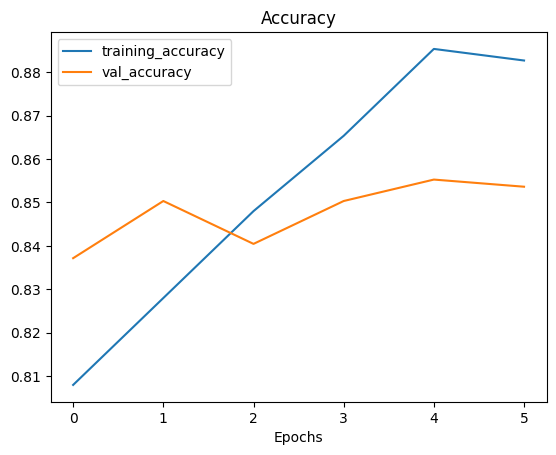

In [53]:
# Checkout the loss curvesofour fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [54]:
# Let's create a function to compare training histories

def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss =  original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine oiginal history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

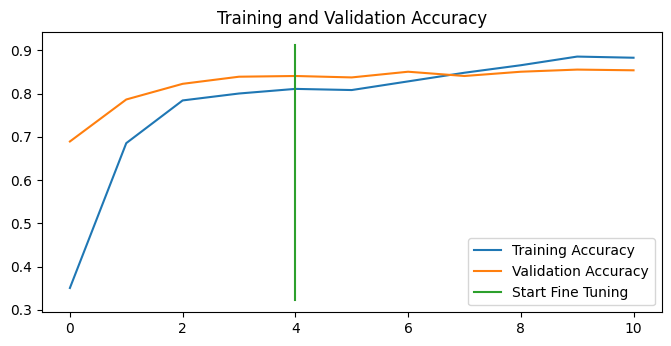

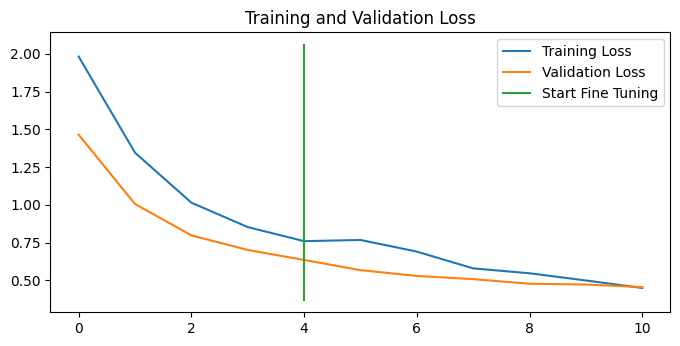

In [66]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## model 4: Fine-tuning and existing model on all of the data

In [65]:
# download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2025-09-29 17:11:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.9MB/s    in 23s     

2025-09-29 17:11:53 (21.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [67]:
# Setup trainin and test dir
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [69]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.